In [1]:
#Add new directory to path to import ngs and pserm
import sys
import os
path = os.getcwd()
path_with_ngs_and_pserm = os.path.dirname(path)

sys.path.append(path_with_ngs_and_pserm)

#Imports 
import tqdm
import glob
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from ngs import NGS_round_data, NGS_DMD, common_clones
from pserm import ngs_analysis, generate_clone_set, score_seq
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import spearmanr, pearsonr

#specify font properties for better export into adobe illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#Add myriad pro font
fpath = "/Library/Fonts/Myriad Pro Regular.ttf"
aapath = '/Library/Fonts/cour.ttf'

prop = fm.FontProperties(fname=fpath, size = 20)
tickprop = fm.FontProperties(fname = fpath, size = 16)
aaprop = fm.FontProperties(fname = aapath, size = 16)

NGS package imported


# Create Project 1 analysis objects and load in PSERMs and score

In [2]:
p1_wt = 'YRRRGAWY'

p1_muts_no_wt = {
0: ['A', 'D', 'F', 'S', 'V'],
1: ['A', 'E', 'G', 'K', 'T'],
2: ['A', 'E', 'G', 'K', 'T'],
3: ['A', 'E', 'G', 'K', 'T'],
4: ['A', 'D', 'N', 'S', 'T'],
5: ['D', 'F', 'S', 'V', 'Y'],
6: ['L', 'G', 'V', 'S', 'A'],
7: ['A', 'D', 'F', 'S', 'V']
}

p1_r1 = NGS_round_data(
    Round = 3, 
    sequence_type = 'mutations', 
    samples =[
        'Input', 'Ag1_P', 'Ag01_P', 'DA_P', 'PSR_P', 'PSR_N', 
        'Ins_P', 'Ins_N', 'Ova_P', 'Ova_N'],
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_1/Rep_1', 
    wild_type = p1_wt, 
    mutations_dict = p1_muts_no_wt
)

p1_r2 = NGS_round_data(
    Round = 3, 
    sequence_type = 'mutations', 
    samples =[
        'Input', 'Ag1_P', 'Ag01_P', 'DA_P', 'PSR_P', 'PSR_N', 'PSR_NB', 
        'Ins_P', 'Ins_NS', 'Ins_NB', 'Ova_P', 'Ova_N', 'Ova_NB'],
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_1/Rep_2', 
    wild_type = p1_wt, 
    mutations_dict = p1_muts_no_wt
)

p1_clone_set_trimmed_r1 = generate_clone_set(p1_r1, ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N', 'Ins_P'])
p1_clone_set_trimmed_r2 = generate_clone_set(p1_r2, ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N', 'Ins_P'])
p1_clone_set_trimmed = list(set(p1_clone_set_trimmed_r1).union(set(p1_clone_set_trimmed_r2)))

p1_data = ngs_analysis([p1_r1, p1_r2], ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N'], clone_set = p1_clone_set_trimmed)

p1_data.generate_D()


['Mutation_139624.csv', 'Mutation_139625.csv', 'Mutation_139626.csv', 'Mutation_139627.csv', 'Mutation_139628.csv', 'Mutation_139629.csv', 'Mutation_139630.csv', 'Mutation_139631.csv', 'Mutation_139632.csv', 'Mutation_139633.csv']


['Mutation_140403.csv', 'Mutation_140404.csv', 'Mutation_140405.csv', 'Mutation_140406.csv', 'Mutation_140407.csv', 'Mutation_140408.csv', 'Mutation_140409.csv', 'Mutation_140410.csv', 'Mutation_140411.csv', 'Mutation_140412.csv', 'Mutation_140413.csv', 'Mutation_140414.csv', 'Mutation_140415.csv']


100%|██████████| 774931/774931 [00:01<00:00, 548791.88it/s]


In [3]:
for sample in ['Input', 'Ag1_P', 'Ag01_P', 'Ova_P', 'Ova_N']:
    p1_data.generate_PSSM(sample)
    if sample != 'Input':
        p1_data.generate_PSERM(In_sample = 'Input', Out_sample = sample)

Generating MSA.


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


In [4]:
p1_data.score_all_clones_mp(method = 'PSSM')
p1_data.score_all_clones_mp(method = 'PSERM')

Done in 8.72 minutes
Done in 12.12 minutes


## Fig S1 Ag and Ovalbumin PSERM

bdat NOT subset; don't know how to subset; dropped
bloc NOT subset; don't know how to subset; dropped


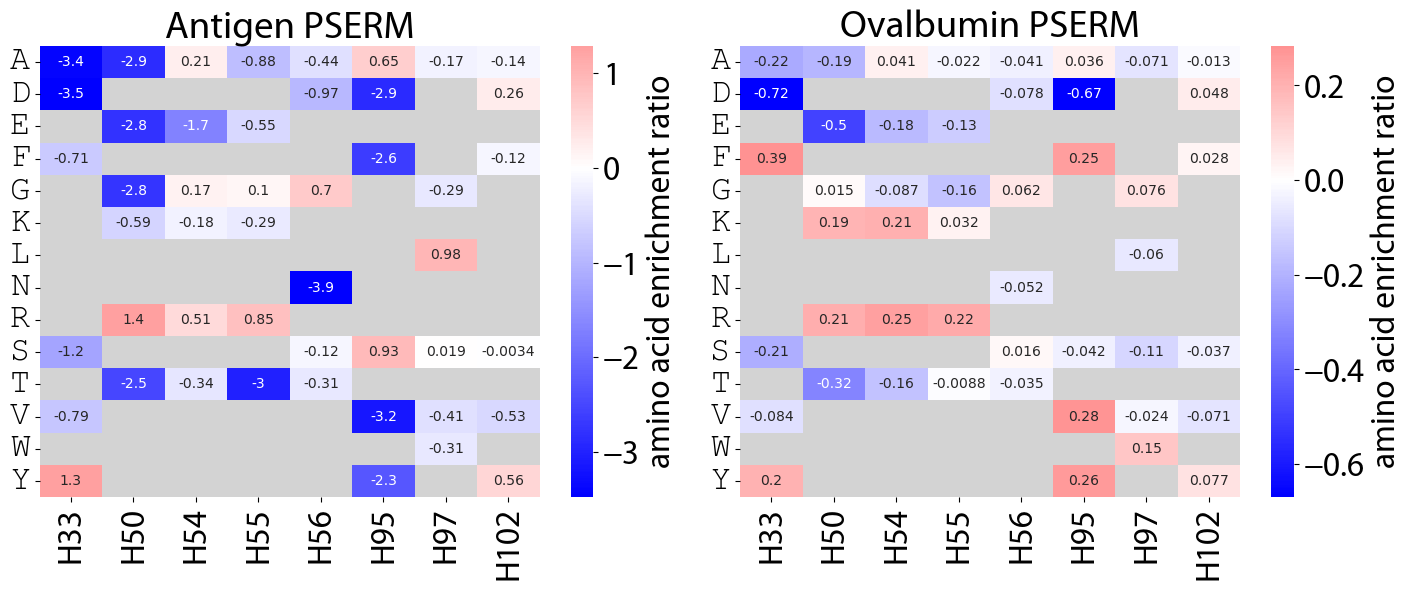

In [84]:
fig, axs = plt.subplots(1, 2, figsize = (7.2 * 2, 6))

prop = fm.FontProperties(fname=fpath, size = 28)
tickprop = fm.FontProperties(fname = fpath, size = 24)
aaprop = fm.FontProperties(fname = aapath, size = 24)

aas = sorted(p1_data.AA_order)

mask = np.ones_like(p1_data.PSERM['Ag01_P'])
for j in p1_data.library.keys():
    for aa in p1_data.library[j]:
        i = aas.index(aa)
        mask[i, j] = 0

rows_to_drop = []
for i in range(mask.shape[0]):
    if mask[i, :].mean() == 1:
        rows_to_drop.append(aas[i])

PSERM = p1_data.PSERM['Ag01_P'].drop(rows_to_drop, axis = 'index').sort_index()
PSERM2 = p1_data.PSERM['Ova_P'].drop(rows_to_drop, axis = 'index').sort_index()

updated_mask = np.zeros_like(PSERM)
row_ind = 0
for i in range(mask.shape[0]):
    if mask[i, :].mean() != 1:
        updated_mask[row_ind, :] = mask[i, :]
        row_ind += 1

sns.heatmap(PSERM, robust = True, cmap = 'bwr', ax = axs[0], mask = updated_mask, center = 0, annot = True)
sns.heatmap(PSERM2, robust = True, cmap = 'bwr', ax = axs[1], mask = updated_mask, center = 0, annot = True)
    
xlabels = ['H33', 'H50', 'H54', 'H55', 'H56', 'H95', 'H97', 'H102']

for ax in axs.ravel():
    ax.set_xticks([i + 0.5 for i in range(len(xlabels))])
    ax.set_xticklabels(xlabels, rotation = 90)
    
    colorbar = ax.collections[0].colorbar
    colorbar.set_label(f'amino acid enrichment ratio', fontproperties = tickprop)
    for tick in colorbar.ax.get_yticklabels():
        tick.set_fontproperties(tickprop)

    ax.set_facecolor('lightgrey')
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(aaprop)
        tick.set_rotation(0)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)



axs[0].set_title('Antigen PSERM', fontproperties = prop)
axs[1].set_title('Ovalbumin PSERM', fontproperties = prop) 

plt.tight_layout()
plt.savefig('Fig. S1 PSERMs.pdf', bbox_inches = 'tight')
plt.show()


# Read in experimental measurements

In [10]:
p1_binding = pd.read_excel('p1_binding_with_ngs_scores.xlsx', index_col = 0)

ag_overlap = set(p1_binding.index)
excluded_ag_seqs = set(p1_binding[p1_binding['ANT ER'].isna()].index)
excluded_ag_seqs = excluded_ag_seqs.union(set(p1_binding[p1_binding['ANT Frequency'].isna()].index))
excluded_ag_seqs = excluded_ag_seqs.union(set(p1_binding[p1_binding['ANT PSSM Score'].isna()].index))
excluded_ag_seqs = excluded_ag_seqs.union(set(p1_binding[p1_binding['ANT PSERM Score'].isna()].index))

ag_overlap = list(ag_overlap - excluded_ag_seqs)

ova_overlap = set(p1_binding.index)
excluded_ova_seqs = set(p1_binding[p1_binding['OVA ER'].isna()].index)
excluded_ova_seqs = excluded_ova_seqs.union(set(p1_binding[p1_binding['OVA Frequency'].isna()].index))
excluded_ova_seqs = excluded_ova_seqs.union(set(p1_binding[p1_binding['OVA PSSM Score'].isna()].index))
excluded_ova_seqs = excluded_ova_seqs.union(set(p1_binding[p1_binding['OVA PSERM Score'].isna()].index))

ova_overlap = list(ova_overlap - excluded_ova_seqs)

## Add ngs metrics

In [5]:
p1_binding = pd.read_excel('p1_binding.xlsx', index_col = 0)

ag_freq_seqs = []
ag_er_seqs = []
ag_pserm_seqs = []

ova_freq_seqs = []
ova_er_seqs = []
ova_pserm_seq = []
for seq in p1_binding.index:
    ###################Ag01########################

    try:
        fo = p1_data.D.loc[seq, 'Ag01_P']
        if fo != 0:
            ag_freq_seqs.append(seq)
            p1_binding.loc[seq, 'ANT Frequency'] = fo
    except:
        pass

    try:
        fo = p1_data.D.loc[seq, 'Ag01_P'] 
        fi = p1_data.D.loc[seq, 'Input']
        if fo != 0 and fi != 0:
            ag_er_seqs.append(seq)
            p1_binding.loc[seq, 'ANT ER'] = np.log2(fo / fi)
        else:
            raise ValueError
    except:
        pass

    try:
        p1_binding.loc[seq, 'ANT PSSM Score'] = p1_data.scores.loc[seq, 'Ag01_P PSSM Score']
    except:
        pass

    try:
        ag_pserm_seqs.append(seq)
        p1_binding.loc[seq, 'ANT PSERM Score'] = p1_data.scores.loc[seq, 'Ag01_P PSERM Score']
    except:
        pass
    
    ##################OVA###################
    try:
        fo = p1_data.D.loc[seq, 'Ova_P']
        if fo != 0:
            ova_freq_seqs.append(seq)
            p1_binding.loc[seq, 'OVA Frequency'] = fo
    except:
        pass

    try:
        fo = p1_data.D.loc[seq, 'Ova_P'] 
        fi = p1_data.D.loc[seq, 'Input']
        if fo != 0 and fi != 0:
            ova_er_seqs.append(seq)
            p1_binding.loc[seq, 'OVA ER'] = np.log2(fo / fi)
        else:
            raise ValueError
    except:
        pass

    try:
        p1_binding.loc[seq, 'OVA PSSM Score'] = p1_data.scores.loc[seq, 'Ova_P PSSM Score']
    except:
        pass

    try:
        ova_pserm_seq.append(seq)
        p1_binding.loc[seq, 'OVA PSERM Score'] = p1_data.scores.loc[seq, 'Ova_P PSERM Score']
    except:
        pass

In [6]:
p1_binding.to_excel('p1_binding_with_ngs_scores.xlsx')

# Figure 4A and 4B

In [7]:
def create_binding_correlations(binding_data_excel, fname, reagent, sample_name, color = None, show = True, show_titles = False, ylims = None):
    #Not very modular with ANT/Antigen being hardcoded
    binding = pd.read_excel(binding_data_excel)
    if color is None:
        color = plt.get_cmap('tab10')(0)
    if '(1)' in sample_name:
        binding_sample = sample_name.split('(')[0]
        print(binding_sample, sample_name)
    else:
        binding_sample = sample_name

    fig, axs = plt.subplots(1, 4, figsize = (8.2*1.8, 1.82*2))
    ################### Frequency ####################
    if show_titles:
        axs[0].set_title('Output Frequency', fontproperties = prop)

    ant_rf, ant_pf = spearmanr(
        binding[f'{sample_name} Frequency'], 
        binding[f'{binding_sample} Binding'], nan_policy = 'omit')

    ant_freq_N = len(binding) - list(binding[f'{sample_name} Frequency'].isna().values).count(True)
    axs[0].set_xscale('log')
    axs[0].plot(
        binding[f'{sample_name} Frequency'], 
        binding[f'{binding_sample} Binding'], '.', markersize = 15, 
        label = r'$\rho =$' + f'{ant_rf:.3}\np={ant_pf:.3}' + f'\nN = {ant_freq_N:,}',
        color = color
    )
    axs[0].set_xlabel(f'{reagent} frequency', fontproperties = prop)
    axs[0].set_ylabel(f'Normalized {sample_name} binding', fontproperties = prop)

    #################ANT ER#####################
    if show_titles:
        axs[1].set_title('Enrichment Ratio', fontproperties = prop)

    ant_rer, ant_per = spearmanr(
        binding[f'{sample_name} ER'], 
        binding[f'{binding_sample} Binding'], nan_policy = 'omit')

    ant_er_N = len(binding) - list(binding[f'{sample_name} ER'].isna().values).count(True)
    axs[1].plot(
        binding[f'{sample_name} ER'], 
        binding[f'{binding_sample} Binding'], '.', markersize = 15, 
        label = r'$\rho =$' + f'{ant_rer:.3}\np={ant_per:.3}' + f'\nN = {ant_er_N:,}',
        color = color
    )
    axs[1].set_xlabel(f'{reagent} enrichment ratio', fontproperties = prop)

    ###############ANT PSSM#####################
    if show_titles:
        axs[2].set_title('Output PSSM score', fontproperties = prop)

    ant_rpssm, ant_ppssm = spearmanr(
        binding[f'{sample_name} PSSM Score'], 
        binding[f'{binding_sample} Binding'], nan_policy = 'omit')

    ant_pssm_N = len(binding) - list(binding[f'{sample_name} PSSM Score'].isna().values).count(True)
    axs[2].plot(
        binding[f'{sample_name} PSSM Score'], 
        binding[f'{binding_sample} Binding'], '.', markersize = 15, 
        label = r'$\rho =$' + f'{ant_rpssm:.3}\np={ant_ppssm:.3}' + f'\nN = {ant_pssm_N:,}',
        color = color
    )
    axs[2].set_xlabel(f'{reagent} PSSM score', fontproperties = prop)

    ###############ANT PSERM#################
    if show_titles:
        axs[3].set_title('PSERM score', fontproperties = prop)

    ant_rPSERM, ant_pPSERM = spearmanr(
        binding[f'{sample_name} PSERM Score'], 
        binding[f'{binding_sample} Binding'], nan_policy = 'omit')

    ant_PSERM_N = len(binding) - list(binding[f'{sample_name} PSERM Score'].isna().values).count(True)
    axs[3].plot(
        binding[f'{sample_name} PSERM Score'], 
        binding[f'{binding_sample} Binding'], '.', markersize = 15, 
        label = r'$\rho =$' + f'{ant_rPSERM:.3}\np={ant_pPSERM:.3}' + f'\nN = {ant_PSERM_N:,}',
        color = color
    )
    axs[3].set_xlabel(f'{reagent} PSERM score', fontproperties = prop)

    #Format
    for ax in axs.ravel():
        if ylims is not None:
            ax.set_ylim(ylims)
        
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(tickprop)
        for tick in ax.get_yticklabels():
            tick.set_fontproperties(tickprop)

        legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
        for marker in legend.legendHandles:
            marker.set_visible(False)
        
    plt.tight_layout()
    if fname is not None:
        if not fname.endswith('.pdf'):
            fname = f'{fname}.pdf'
        else:
            plt.savefig(fname, transparent = True)
    if show:
        plt.show()

/var/folders/_k/l4n5p27503v3vnw_5p9dvdsw0000gn/T/ipykernel_54645/2523406247.py:94: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for marker in legend.legendHandles:


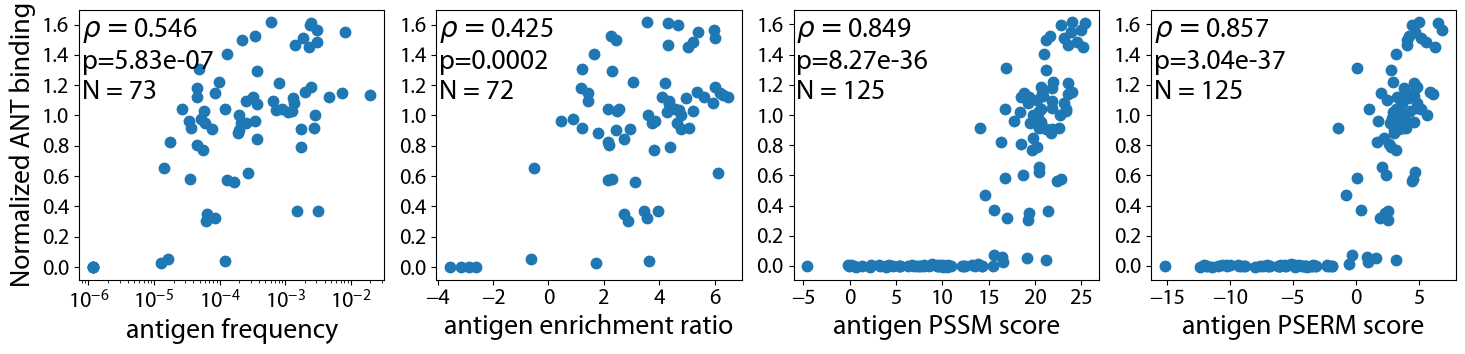

/var/folders/_k/l4n5p27503v3vnw_5p9dvdsw0000gn/T/ipykernel_54645/2523406247.py:94: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for marker in legend.legendHandles:


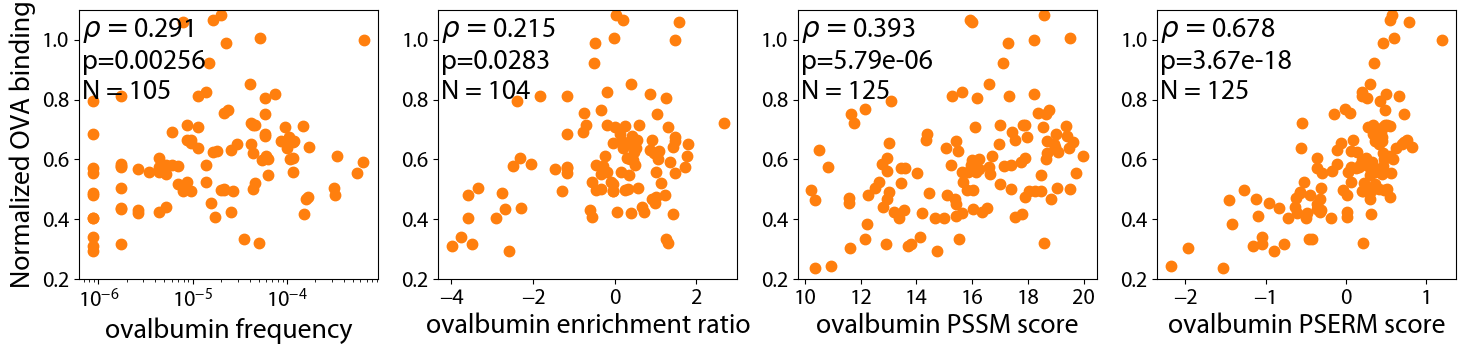

In [9]:
create_binding_correlations(
    binding_data_excel = 'p1_binding_with_ngs_scores.xlsx', 
    fname = 'Fig. 4A Antigen Binding Correlations.pdf',
    show = True, reagent = 'antigen', sample_name = 'ANT', show_titles=False
    )

create_binding_correlations(
    binding_data_excel = 'p1_binding_with_ngs_scores.xlsx', 
    fname = 'Fig. 4B Ovalbumin Binding Correlations.pdf',
    show = True, reagent = 'ovalbumin', sample_name = 'OVA', color = plt.get_cmap('tab10')(1),
    ylims = (0.2, 1.1), show_titles=False
    )

## Plot ANT common clone set

/var/folders/_k/l4n5p27503v3vnw_5p9dvdsw0000gn/T/ipykernel_54645/2892848021.py:69: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for marker in legend.legendHandles:


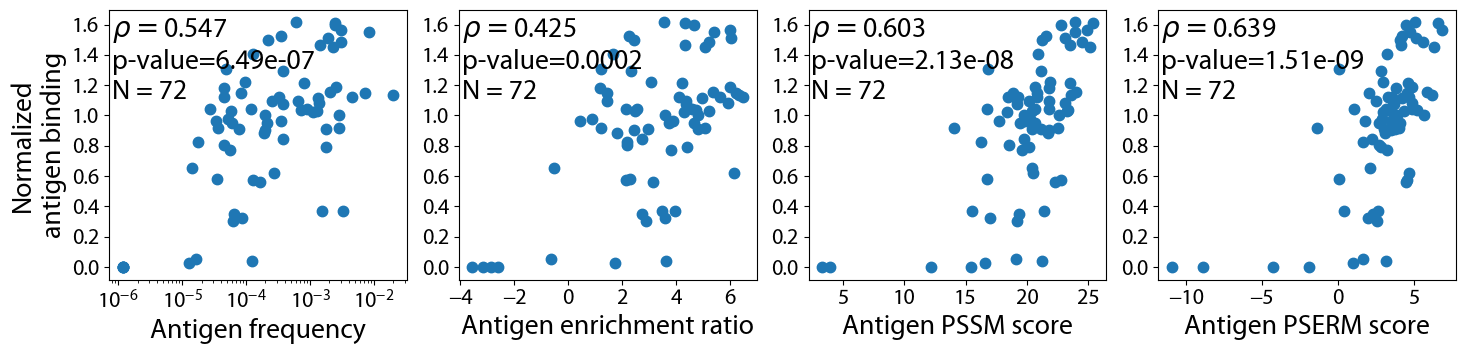

In [11]:
fig, axs = plt.subplots(1, 4, figsize = (8.2*1.8, 1.82*2))

############### ANT FREQUENCY #################
#axs[0].set_title('Output Frequency', fontproperties = prop)
p1_ant_rf, p1_ant_pf = spearmanr(
    p1_binding.loc[ag_overlap, 'ANT Frequency'], 
    p1_binding.loc[ag_overlap, 'ANT Binding'], nan_policy = 'omit')

p1_ant_freq_N = len(ag_overlap)
axs[0].set_xscale('log')
axs[0].plot(
    p1_binding.loc[ag_overlap, 'ANT Frequency'], 
    p1_binding.loc[ag_overlap, 'ANT Binding'], '.', markersize = 15, 
    label = r'$\rho =$' + f'{p1_ant_rf:.3}\np-value={p1_ant_pf:.3}' + f'\nN = {p1_ant_freq_N:,}'
)
axs[0].set_xlabel('Antigen frequency', fontproperties = prop)
axs[0].set_ylabel('Normalized\nantigen binding', fontproperties = prop)

#################ANT ER#####################
#axs[1].set_title('Enrichment Ratio', fontproperties = prop)
p1_ant_rer, p1_ant_per = spearmanr(
    p1_binding.loc[ag_overlap, 'ANT ER'], 
    p1_binding.loc[ag_overlap, 'ANT Binding'], nan_policy = 'omit')

p1_ant_er_N = len(ag_overlap)
axs[1].plot(
    p1_binding.loc[ag_overlap, 'ANT ER'], 
    p1_binding.loc[ag_overlap, 'ANT Binding'], '.', markersize = 15, 
    label = r'$\rho =$' + f'{p1_ant_rer:.3}\np-value={p1_ant_per:.3}' + f'\nN = {p1_ant_er_N:,}'
)
axs[1].set_xlabel('Antigen enrichment ratio', fontproperties = prop)

###############ANT PSSM#####################
#axs[2].set_title('Output PSSM score', fontproperties = prop)
p1_ant_rpssm, p1_ant_ppssm = spearmanr(
    p1_binding.loc[ag_overlap, 'ANT PSSM Score'], 
    p1_binding.loc[ag_overlap, 'ANT Binding'], nan_policy = 'omit')

p1_ant_pssm_N = len(ag_overlap)
axs[2].plot(
    p1_binding.loc[ag_overlap, 'ANT PSSM Score'], 
    p1_binding.loc[ag_overlap, 'ANT Binding'], '.', markersize = 15, 
    label = r'$\rho =$' + f'{p1_ant_rpssm:.3}\np-value={p1_ant_ppssm:.3}' + f'\nN = {p1_ant_pssm_N:,}'
)
axs[2].set_xlabel('Antigen PSSM score', fontproperties = prop)

###############ANT PSERM#################
#axs[3].set_title('PSERM score', fontproperties = prop)
p1_ant_rPSERM, p1_ant_pPSERM = spearmanr(
    p1_binding.loc[ag_overlap, 'ANT PSERM Score'], 
    p1_binding.loc[ag_overlap, 'ANT Binding'], nan_policy = 'omit')

p1_ant_PSERM_N = len(ag_overlap)
axs[3].plot(
    p1_binding.loc[ag_overlap, 'ANT PSERM Score'], 
    p1_binding.loc[ag_overlap, 'ANT Binding'], '.', markersize = 15, 
    label = r'$\rho =$' + f'{p1_ant_rPSERM:.3}\np-value={p1_ant_pPSERM:.3}' + f'\nN = {p1_ant_PSERM_N:,}'
)
axs[3].set_xlabel('Antigen PSERM score', fontproperties = prop)

#Format
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)

    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)

plt.tight_layout()
plt.savefig('Fig. S2 A Antigen Binding Correlations Common Seq Set.pdf')
plt.show()

## Plot Ovalbumin common clone set

/var/folders/_k/l4n5p27503v3vnw_5p9dvdsw0000gn/T/ipykernel_54645/3942333987.py:69: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for marker in legend.legendHandles:


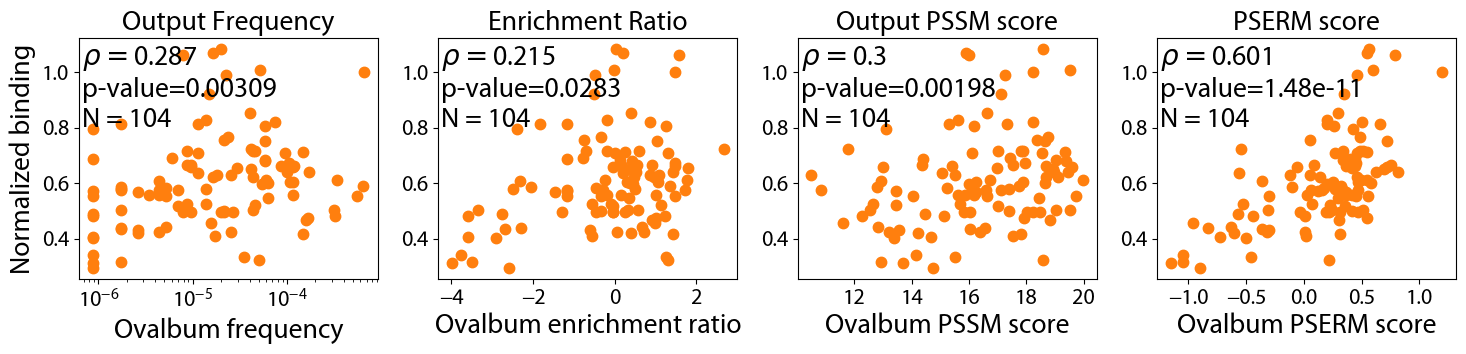

In [12]:
fig, axs = plt.subplots(1, 4, figsize = (8.2*1.8, 1.82*2))

############### OVA FREQUENCY #################
axs[0].set_title('Output Frequency', fontproperties = prop)
p1_OVA_rf, p1_OVA_pf = spearmanr(
    p1_binding.loc[ova_overlap, 'OVA Frequency'], 
    p1_binding.loc[ova_overlap, 'OVA Binding'], nan_policy = 'omit')

p1_OVA_freq_N = len(ova_overlap)
axs[0].set_xscale('log')
axs[0].plot(
    p1_binding.loc[ova_overlap, 'OVA Frequency'], 
    p1_binding.loc[ova_overlap, 'OVA Binding'], '.', markersize = 15, color = plt.get_cmap('tab10')(1),
    label = r'$\rho =$' + f'{p1_OVA_rf:.3}\np-value={p1_OVA_pf:.3}' + f'\nN = {p1_OVA_freq_N:,}'
)
axs[0].set_xlabel('Ovalbum frequency', fontproperties = prop)
axs[0].set_ylabel('Normalized binding', fontproperties = prop)

#################OVA ER#####################
axs[1].set_title('Enrichment Ratio', fontproperties = prop)
p1_OVA_rer, p1_OVA_per = spearmanr(
    p1_binding.loc[ova_overlap, 'OVA ER'], 
    p1_binding.loc[ova_overlap, 'OVA Binding'], nan_policy = 'omit')

p1_OVA_er_N = len(ova_overlap)
axs[1].plot(
    p1_binding.loc[ova_overlap, 'OVA ER'], 
    p1_binding.loc[ova_overlap, 'OVA Binding'], '.', markersize = 15, color = plt.get_cmap('tab10')(1),
    label = r'$\rho =$' + f'{p1_OVA_rer:.3}\np-value={p1_OVA_per:.3}' + f'\nN = {p1_OVA_er_N:,}'
)
axs[1].set_xlabel('Ovalbum enrichment ratio', fontproperties = prop)

###############OVA PSSM#####################
axs[2].set_title('Output PSSM score', fontproperties = prop)
p1_OVA_rpssm, p1_OVA_ppssm = spearmanr(
    p1_binding.loc[ova_overlap, 'OVA PSSM Score'], 
    p1_binding.loc[ova_overlap, 'OVA Binding'], nan_policy = 'omit')

p1_OVA_pssm_N = len(ova_overlap)
axs[2].plot(
    p1_binding.loc[ova_overlap, 'OVA PSSM Score'], 
    p1_binding.loc[ova_overlap, 'OVA Binding'], '.', markersize = 15, color = plt.get_cmap('tab10')(1),
    label = r'$\rho =$' + f'{p1_OVA_rpssm:.3}\np-value={p1_OVA_ppssm:.3}' + f'\nN = {p1_OVA_pssm_N:,}'
)
axs[2].set_xlabel('Ovalbum PSSM score', fontproperties = prop)

###############OVA PSERM#################
axs[3].set_title('PSERM score', fontproperties = prop)
p1_OVA_rPSERM, p1_OVA_pPSERM = spearmanr(
    p1_binding.loc[ova_overlap, 'OVA PSERM Score'], 
    p1_binding.loc[ova_overlap, 'OVA Binding'], nan_policy = 'omit')

p1_OVA_PSERM_N = len(ova_overlap)
axs[3].plot(
    p1_binding.loc[ova_overlap, 'OVA PSERM Score'], 
    p1_binding.loc[ova_overlap, 'OVA Binding'], '.', markersize = 15, color = plt.get_cmap('tab10')(1),
    label = r'$\rho =$' + f'{p1_OVA_rPSERM:.3}\np-value={p1_OVA_pPSERM:.3}' + f'\nN = {p1_OVA_PSERM_N:,}'
)
axs[3].set_xlabel('Ovalbum PSERM score', fontproperties = prop)

#Format
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)

    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)

plt.tight_layout()
plt.savefig('Fig. S2 B Ovalbumin Binding Correlations Common Seq Set.pdf')
plt.show()

# Ag1_P analysis

/var/folders/_k/l4n5p27503v3vnw_5p9dvdsw0000gn/T/ipykernel_54645/292892417.py:43: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for marker in legend.legendHandles:


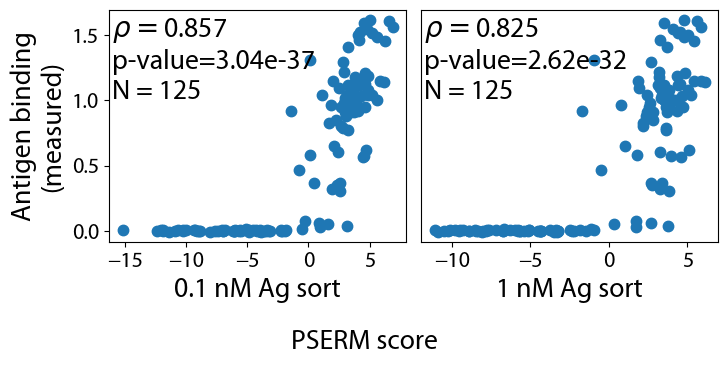

In [27]:
fig, axs = plt.subplots(1, 2, figsize = (8.2*1.8 / 2, 1.82*2))

#ANT 0.1 nM Sort
p1_ant_rPSERM, p1_ant_pPSERM = spearmanr(
    p1_binding['ANT PSERM Score'], 
    p1_binding['ANT Binding'], nan_policy = 'omit')

p1_ant_PSERM_N = len(p1_binding) - list(p1_binding['ANT PSERM Score'].isna().values).count(True)
axs[0].plot(
    p1_binding['ANT PSERM Score'], 
    p1_binding['ANT Binding'], '.', markersize = 15, 
    label = r'$\rho =$' + f'{p1_ant_rPSERM:.3}\np-value={p1_ant_pPSERM:.3}' + f'\nN = {p1_ant_PSERM_N:,}'
)

ag1_pserm_scores = []
ant_binding = []
for seq in p1_binding.index:
    if not pd.isna(p1_binding.loc[seq, 'ANT PSERM Score']):
        ag1_pserm_scores.append(p1_data.scores.loc[seq, 'Ag1_P PSERM Score'])
        ant_binding.append(p1_binding.loc[seq, 'ANT Binding'])

p1_ant1_rPSERM, p1_ant1_pPSERM = spearmanr(
    ag1_pserm_scores, ant_binding, nan_policy = 'omit')

p1_ant1_PSERM_N = len(ag1_pserm_scores)
axs[1].plot(
    ag1_pserm_scores, 
    ant_binding, '.', markersize = 15, 
    label = r'$\rho =$' + f'{p1_ant1_rPSERM:.3}\np-value={p1_ant1_pPSERM:.3}' + f'\nN = {p1_ant1_PSERM_N:,}'
)

axs[0].set_yticks([0, 0.5, 1, 1.5])
axs[1].set_yticks([])

#Format
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)

    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)

axs[0].set_ylabel('Antigen binding\n(measured)', fontproperties = prop)
axs[0].set_xlabel('0.1 nM Ag sort', fontproperties = prop)
axs[1].set_xlabel('1 nM Ag sort', fontproperties = prop)

fig.supxlabel('PSERM score', fontproperties = prop)

plt.tight_layout()
plt.savefig('Fig. S3 Antigen 1 nM Binding PSERM correlations.pdf')
plt.show()

# Histogram of seen vs unseen clones

In [36]:
#Create every clone designed within the library.
import itertools

mutation_str_length = len(p1_data.wt)
num_mutations = mutation_str_length

mut_loc_dict  = {i: loc for i, loc in enumerate(list(itertools.combinations(list(range(mutation_str_length)), num_mutations)))}

#create possible mutations dictionary -- Fast
mutation_number = 0
mutations_dictionary = {}

for loc in tqdm.tqdm(mut_loc_dict.values()):
    mutations_dictionary_subkey = ''
    for i in loc:
        mutations_dictionary_subkey += str(i) + ','
    key_list = [i for i in mutations_dictionary_subkey.split(',') if i != '']
    product_list = [p1_data.library[int(j)] for j in key_list]
    possible_mutations = list(itertools.product(*product_list))
    for m in possible_mutations:
        mutations_dictionary[mutation_number] = ''.join(m)

        mutation_number += 1

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


In [95]:
#create list of unseen mutants
unseen_clones = []

for i, seq in tqdm.tqdm(mutations_dictionary.items()):
    if seq not in p1_data.scores.index:
        unseen_clones.append(seq)

#Score all unseen clones with antigen PSERM
unseen_scores = {}
for seq in tqdm.tqdm(unseen_clones):
    unseen_scores[seq] = score_seq(p1_data.PSERM['Ag01_P'], seq) 
unseen_scores_df = pd.DataFrame.from_dict(
    unseen_scores, orient = 'index', columns = ['Ag01_P PSERM Score'])

#Combine dataframes to plot box and whisker easier
seen_scores = pd.DataFrame(p1_data.scores.loc[:, 'Ag01_P PSERM Score'])
seen_scores['kind'] = 'Observed\nsequences'
unseen_scores_df['kind'] = 'Unobserved\nsequences'
both = pd.concat((seen_scores, unseen_scores_df))

100%|██████████| 449853/449853 [00:22<00:00, 19810.06it/s]


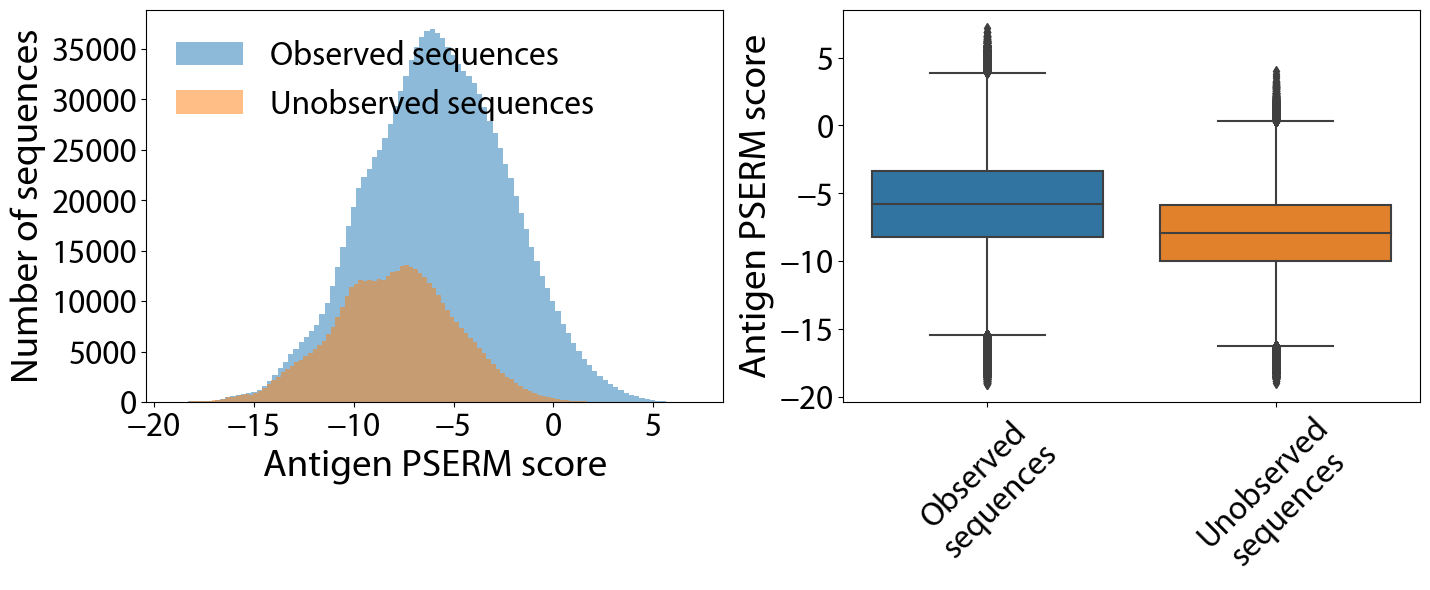

In [96]:
fig, axs = plt.subplots(1, 2, figsize = (7.2 * 2, 6))

#PLOT HISTOGRAM OF SCORES
axs[0].hist(p1_data.scores['Ag01_P PSERM Score'], bins = 100, alpha = 0.5,
        label = 'Observed sequences')
axs[0].hist(unseen_scores_df['Ag01_P PSERM Score'], bins = 100, alpha = 0.5,
        label = 'Unobserved sequences')

axs[0].set_xlabel('Antigen PSERM score', fontproperties = prop)
axs[0].set_ylabel('Number of sequences', fontproperties = prop)

#PLOT BOX AND WHISKER TO SHOW ANY OUTLIERS
sns.boxplot(data = both,
            x = 'kind', 
            y = 'Ag01_P PSERM Score', 
            ax = axs[1])

axs[1].set_ylabel('Antigen PSERM score', fontproperties = prop)
axs[1].set_xlabel('')

for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)
        
axs[0].legend(prop = tickprop, loc = 2, frameon = False)

axs[1].set_xticks(
        axs[1].get_xticks(),
        axs[1].get_xticklabels(), 
        fontproperties = tickprop, rotation = 45)

plt.tight_layout()
plt.savefig('Fig. S4 A Unseen clones antigen scores.pdf')
plt.show()

## Non-sepcific unseen clones

In [ ]:
#Score all unseen clones with ova_p PSERM
unseen_ova_scores = {}
for seq in tqdm.tqdm(unseen_clones):
    unseen_ova_scores[seq] = score_seq(p1_data.PSERM['Ova_P'], seq) 
unseen_ova_scores_df = pd.DataFrame.from_dict(
    unseen_ova_scores, orient = 'index', columns = ['Ova_P PSERM Score'])

#Combine dataframes to plot box and whisker easier
seen_ova_scores = pd.DataFrame(p1_data.scores.loc[:, 'Ova_P PSERM Score'])
seen_ova_scores['kind'] = 'Observed\nsequences'
unseen_ova_scores_df['kind'] = 'Unobserved\nsequences'
both_ova = pd.concat((seen_ova_scores, unseen_ova_scores_df))

100%|██████████| 449853/449853 [00:22<00:00, 19838.65it/s]


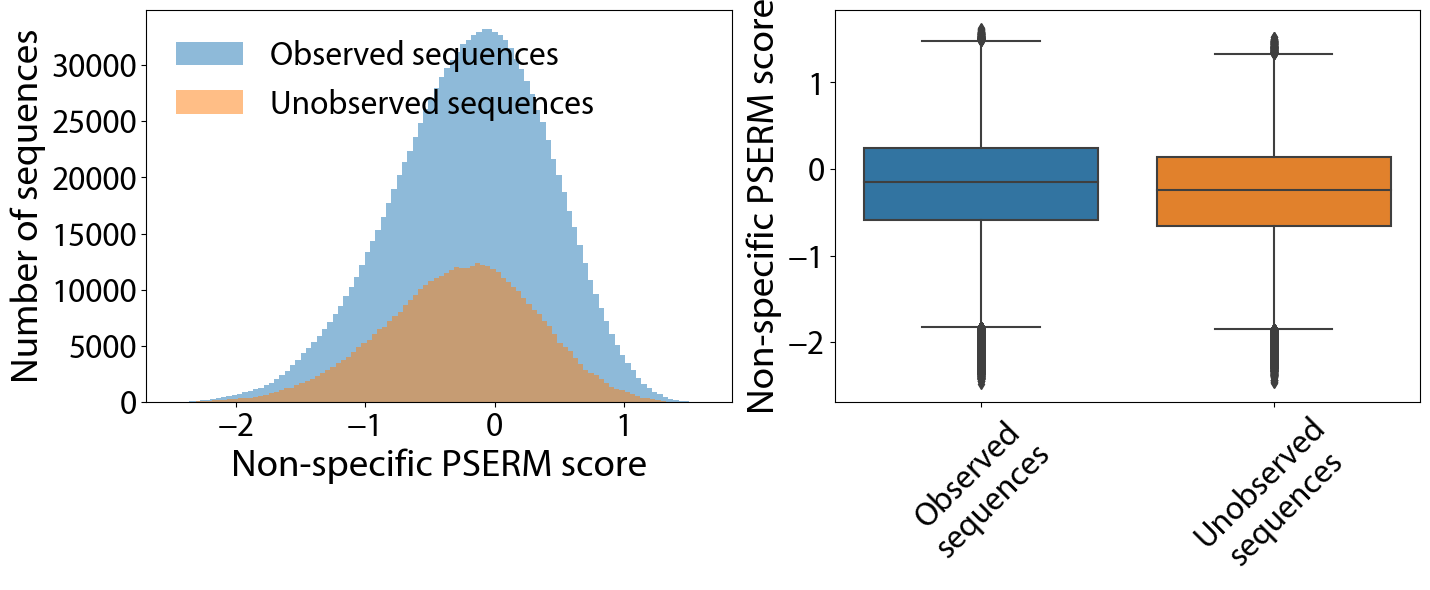

In [98]:
fig, axs = plt.subplots(1, 2, figsize = (7.2 * 2, 6))

#PLOT HISTOGRAM OF SCORES
axs[0].hist(p1_data.scores['Ova_P PSERM Score'], bins = 100, alpha = 0.5,
        label = 'Observed sequences')
axs[0].hist(unseen_ova_scores_df['Ova_P PSERM Score'], bins = 100, alpha = 0.5,
        label = 'Unobserved sequences')

axs[0].set_xlabel('Non-specific PSERM score', fontproperties = prop)
axs[0].set_ylabel('Number of sequences', fontproperties = prop)

#PLOT BOX AND WHISKER TO SHOW ANY OUTLIERS
sns.boxplot(data = both_ova,
            x = 'kind', 
            y = 'Ova_P PSERM Score', 
            ax = axs[1], )
axs[1].set_ylabel('Non-specific PSERM score', fontproperties = prop)
axs[1].set_xlabel('')

for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)

axs[0].legend(prop = tickprop, loc = 2, frameon = False)

axs[1].set_xticks(
        axs[1].get_xticks(),
        axs[1].get_xticklabels(), 
        fontproperties = tickprop, rotation = 45)

plt.tight_layout()
plt.savefig('Fig. S4 B Unseen clones non-specific scores.pdf')
plt.show()

# Top 10 Analysis

In [44]:
pserm_index = p1_binding.columns.tolist().index('ANT PSERM Score')
pssm_index = p1_binding.columns.tolist().index('ANT PSSM Score')
er_index = p1_binding.columns.tolist().index('ANT ER')
freq_index = p1_binding.columns.tolist().index('ANT Frequency')

pserm_cutoff = p1_binding.sort_values(['ANT PSERM Score'], ascending = False).iloc[10,pserm_index]
pssm_cutoff = p1_binding.sort_values(['ANT PSSM Score'], ascending = False).iloc[10,pssm_index]
er_cutoff = p1_binding.sort_values(['ANT ER'], ascending = False).iloc[10,er_index]
freq_cutoff = p1_binding.sort_values(['ANT Frequency'], ascending = False).iloc[10,freq_index]

for c in p1_binding.index:
    if p1_binding.loc[c, 'ANT PSERM Score'] > pserm_cutoff:
        p1_binding.loc[c, 'PSERM Selected'] = 4
    else:
        p1_binding.loc[c, 'PSERM Selected'] = 0
    
    if p1_binding.loc[c, 'ANT PSSM Score'] > pssm_cutoff:
        p1_binding.loc[c, 'PSSM Selected'] = 3
    else:
        p1_binding.loc[c, 'PSSM Selected'] = 0
    
    if p1_binding.loc[c, 'ANT ER'] > er_cutoff:
        p1_binding.loc[c, 'ER Selected'] = 2
    else:
        p1_binding.loc[c, 'ER Selected'] = 0

    if p1_binding.loc[c, 'ANT Frequency'] > freq_cutoff:
        p1_binding.loc[c, 'Frequency Selected'] = 1
    else:
        p1_binding.loc[c, 'Frequency Selected'] = 0

ova_pserm_index = p1_binding.columns.tolist().index('OVA PSERM Score')
ova_pssm_index = p1_binding.columns.tolist().index('OVA PSSM Score')
ova_er_index = p1_binding.columns.tolist().index('OVA ER')
ova_freq_index = p1_binding.columns.tolist().index('OVA Frequency')

ova_pserm_cutoff = p1_binding.sort_values(['OVA PSERM Score']).iloc[10, ova_pserm_index]
ova_pssm_cutoff = p1_binding.sort_values(['OVA PSSM Score']).iloc[10,ova_pssm_index]
ova_er_cutoff = p1_binding.sort_values(['OVA ER']).iloc[10,ova_er_index]
ova_freq_cutoff = p1_binding.sort_values(['OVA Frequency']).iloc[12,ova_freq_index]

for c in p1_binding.index:
    if p1_binding.loc[c, 'OVA PSERM Score'] < ova_pserm_cutoff:
        p1_binding.loc[c, 'OVA PSERM Selected'] = 4
    else:
        p1_binding.loc[c, 'OVA PSERM Selected'] = 0
    
    if p1_binding.loc[c, 'OVA PSSM Score'] < ova_pssm_cutoff:
        p1_binding.loc[c, 'OVA PSSM Selected'] = 3
    else:
        p1_binding.loc[c, 'OVA PSSM Selected'] = 0
    
    if p1_binding.loc[c, 'OVA ER'] < ova_er_cutoff:
        p1_binding.loc[c, 'OVA ER Selected'] = 2
    else:
        p1_binding.loc[c, 'OVA ER Selected'] = 0

    if p1_binding.loc[c, 'OVA Frequency'] < ova_freq_cutoff:
        p1_binding.loc[c, 'OVA Frequency Selected'] = 1
    else:
        p1_binding.loc[c, 'OVA Frequency Selected'] = 0

p1_binding

,ANT Binding,OVA Binding,ANT(1) Frequency,ANT(1) ER,ANT PSSM Score,ANT(1) PSSM Score,ANT PSERM Score,ANT(1) PSERM Score,OVA Frequency,OVA ER,...,ANT Frequency,ANT ER,PSERM Selected,PSSM Selected,ER Selected,Frequency Selected,OVA PSERM Selected,OVA PSSM Selected,OVA ER Selected,OVA Frequency Selected
Mut Str,,,,,,,,,,,,,,,,,,,,,
YRAEASGA,0.605333,0.851332,0.000010,-1.625165,18.708358,19.548081,2.394884,3.234607,0.000041,0.408622,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YRAKGSGA,1.178590,1.081846,0.000050,1.344461,21.787818,21.173843,3.794802,3.180827,0.000020,0.025294,...,0.000044,1.180232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YRAGSSSD,1.497664,0.813501,0.000062,0.642542,21.214666,22.158486,4.080868,5.024688,0.000011,-1.821675,...,0.000217,2.439839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YRRGDSGD,1.407028,0.820071,0.000077,0.929423,20.935746,21.425963,3.210347,3.700564,0.000074,0.863817,...,0.000128,1.653183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SKKGGAWV,0.915810,0.826149,0.000016,0.007426,14.030553,13.734902,-1.401431,-1.697082,0.000014,-0.176340,...,0.000036,1.208429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YKRGSSLF,1.020216,0.558968,0.009624,7.401737,18.407393,18.771855,2.967670,3.332132,0.000115,1.020961,...,0.001106,4.280422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YRAGGSLY,1.137895,0.590936,0.025286,6.660855,23.578762,23.521176,6.152232,6.094646,0.000643,1.364523,...,0.019959,6.319589,4.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0
YRGRGAAA,1.550090,0.554336,0.011988,5.927925,23.906620,23.243809,4.735660,4.072849,0.000551,1.485615,...,0.008252,5.389187,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0


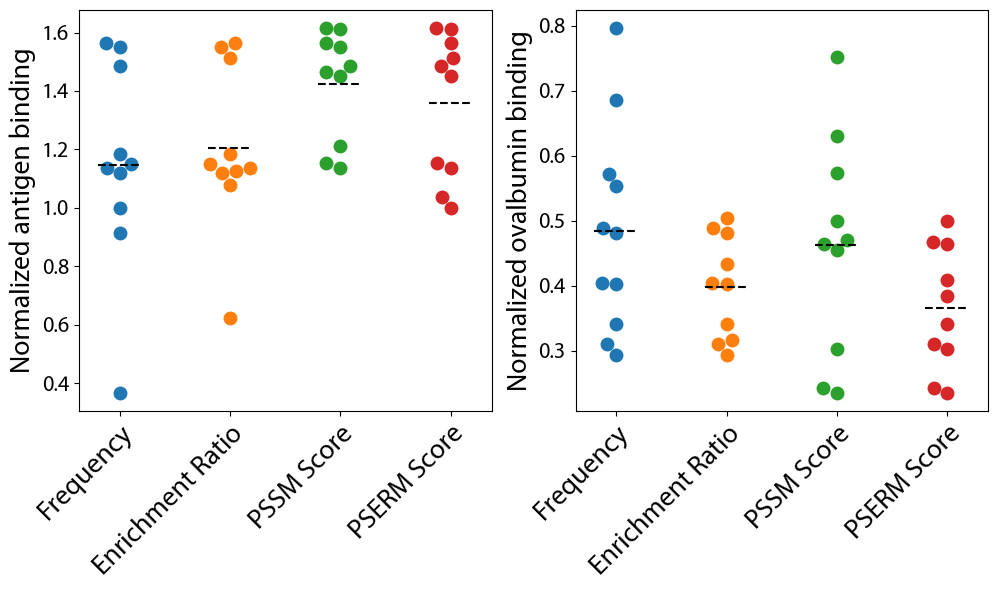

In [55]:
fig, axs = plt.subplots(1, 2, figsize = (7.2 * 1.4, 6))

sns.swarmplot(data=p1_binding[p1_binding['Frequency Selected'] == 1], x= 'Frequency Selected', y="ANT Binding", orient = 'v', ax = axs[0], size = 10)
sns.swarmplot(data=p1_binding[p1_binding['ER Selected'] == 2], x= 'ER Selected', y="ANT Binding", orient = 'v', ax = axs[0], size = 10)
sns.swarmplot(data=p1_binding[p1_binding['PSSM Selected'] == 3], x= 'PSSM Selected', y="ANT Binding", orient = 'v', ax = axs[0], size = 10)
sns.swarmplot(data=p1_binding[p1_binding['PSERM Selected'] == 4], x= 'PSERM Selected', y="ANT Binding", orient = 'v', ax = axs[0], size = 10)

sns.swarmplot(data=p1_binding[p1_binding['OVA Frequency Selected'] == 1], x= 'OVA Frequency Selected', y="OVA Binding", orient = 'v', ax = axs[1], size = 10)
sns.swarmplot(data=p1_binding[p1_binding['OVA ER Selected'] == 2], x= 'OVA ER Selected', y="OVA Binding", orient = 'v', ax = axs[1], size = 10)
sns.swarmplot(data=p1_binding[p1_binding['OVA PSSM Selected'] == 3], x= 'OVA PSSM Selected', y="OVA Binding", orient = 'v', ax = axs[1], size = 10)
sns.swarmplot(data=p1_binding[p1_binding['OVA PSERM Selected'] == 4], x= 'OVA PSERM Selected', y="OVA Binding", orient = 'v', ax = axs[1], size = 10)

ant_f_mean = p1_binding[p1_binding['Frequency Selected'] == 1]['ANT Binding'].mean()
ant_er_mean = p1_binding[p1_binding['ER Selected'] == 2]['ANT Binding'].mean()
ant_pssm_mean = p1_binding[p1_binding['PSSM Selected'] == 3]['ANT Binding'].mean()
ant_pserm_mean = p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'].mean()

ant_f_std = p1_binding[p1_binding['Frequency Selected'] == 1]['ANT Binding'].std()
ant_er_std = p1_binding[p1_binding['ER Selected'] == 2]['ANT Binding'].std()
ant_pssm_std = p1_binding[p1_binding['PSSM Selected'] == 3]['ANT Binding'].std()
ant_pserm_std = p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'].std()

axs[0].plot([-0.2, 0.2], [ant_f_mean, ant_f_mean], '--', color = 'k', zorder = 10)
axs[0].plot([0.8, 1.2], [ant_er_mean, ant_er_mean], '--', color = 'k', zorder = 10)
axs[0].plot([1.8, 2.2], [ant_pssm_mean, ant_pssm_mean], '--', color = 'k', zorder = 10)
axs[0].plot([2.8, 3.2], [ant_pserm_mean, ant_pserm_mean], '--', color = 'k', zorder = 10)

ova_f_mean = p1_binding[p1_binding['OVA Frequency Selected'] == 1]['OVA Binding'].mean()
ova_er_mean = p1_binding[p1_binding['OVA ER Selected'] == 2]['OVA Binding'].mean()
ova_pssm_mean = p1_binding[p1_binding['OVA PSSM Selected'] == 3]['OVA Binding'].mean()
ova_pserm_mean = p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'].mean()

ova_f_std = p1_binding[p1_binding['OVA Frequency Selected'] == 1]['OVA Binding'].std()
ova_er_std = p1_binding[p1_binding['OVA ER Selected'] == 2]['OVA Binding'].std()
ova_pssm_std = p1_binding[p1_binding['OVA PSSM Selected'] == 3]['OVA Binding'].std()
ova_pserm_std = p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'].std()

axs[1].plot([-0.2, 0.2], [ova_f_mean, ova_f_mean], '--', color = 'k', zorder = 10)
axs[1].plot([0.8, 1.2], [ova_er_mean, ova_er_mean], '--', color = 'k', zorder = 10)
axs[1].plot([1.8, 2.2], [ova_pssm_mean, ova_pssm_mean], '--', color = 'k', zorder = 10)
axs[1].plot([2.8, 3.2], [ova_pserm_mean, ova_pserm_mean], '--', color = 'k', zorder = 10)

axs[0].set_ylabel('Normalized antigen binding', fontproperties = prop)
axs[1].set_ylabel('Normalized ovalbumin binding', fontproperties = prop)

for ax in axs:
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)

    ax.set_xticks([0, 1, 2, 3], ['Frequency', 'Enrichment Ratio', 'PSSM Score', 'PSERM Score'], fontproperties = prop, rotation = 45, ha = 'right', rotation_mode = 'anchor')
    ax.set_xlabel('')
plt.tight_layout()
plt.savefig('Fig. 4C Top 10 analysis.pdf')
plt.show()

In [48]:
print(ant_f_mean, ant_f_std)
print(ant_er_mean, ant_er_std)
print(ant_pssm_mean, ant_pssm_std)
print(ant_pserm_mean, ant_pserm_std)
print('\n################\n')
print(ova_f_mean, ova_f_std)
print(ova_er_mean, ova_er_std)
print(ova_pssm_mean, ova_pssm_std)
print(ova_pserm_mean, ova_pserm_std)


1.1474433833000002 0.3555924694091167
1.2045663357 0.28278996398183753
1.4246247685 0.18701406316481672
1.3572774654 0.24589569838566475

################

0.4847944312727272 0.15797313729953338
0.3981408005 0.07887017159012158
0.4626166786 0.16688236760238642
0.36596968890000003 0.09396304361724572


In [50]:
import scipy

t1, p1 = scipy.stats.ttest_ind(
    p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'],
    p1_binding[p1_binding['PSSM Selected'] == 3]['ANT Binding'], 
    equal_var = False, alternative = 'greater'
    )

t2, p2 = scipy.stats.ttest_ind(
    p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'],
    p1_binding[p1_binding['ER Selected'] == 2]['ANT Binding'], 
    equal_var = False, alternative = 'greater'
    )

t3, p3 = scipy.stats.ttest_ind(
    p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'],
    p1_binding[p1_binding['Frequency Selected'] == 1]['ANT Binding'], 
    equal_var = False, alternative = 'greater'
    )

print(p1, p2, p3)


t4, p4 = scipy.stats.ttest_ind(
    p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'],
    p1_binding[p1_binding['OVA PSSM Selected'] == 3]['OVA Binding'], 
    equal_var = False, alternative = 'less'
    )

t5, p5 = scipy.stats.ttest_ind(
    p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'],
    p1_binding[p1_binding['OVA ER Selected'] == 2]['OVA Binding'], 
    equal_var = False, alternative = 'less'
    )

t6, p6 = scipy.stats.ttest_ind(
    p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'],
    p1_binding[p1_binding['OVA Frequency Selected'] == 1]['OVA Binding'], 
    equal_var = False, alternative = 'less'
    )

print(p4, p5, p6)

0.7500017868135678 0.10707448771835695 0.07217814065847629
0.06628141226113564 0.2090635405149432 0.02489879067512525


In [20]:
import scipy

ad1 = scipy.stats.anderson_ksamp(
    [p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'],
    p1_binding[p1_binding['PSSM Selected'] == 3]['ANT Binding']]
    )

ad2 = scipy.stats.anderson_ksamp(
    [p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'],
    p1_binding[p1_binding['ER Selected'] == 2]['ANT Binding']]
    )

ad3 = scipy.stats.anderson_ksamp(
    [p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'],
    p1_binding[p1_binding['Frequency Selected'] == 1]['ANT Binding']]
    )

print(ad1.significance_level, ad2.significance_level, ad3.significance_level)


ad4 = scipy.stats.anderson_ksamp(
    [p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'],
    p1_binding[p1_binding['OVA PSSM Selected'] == 3]['OVA Binding']]
    )

ad5 = scipy.stats.anderson_ksamp(
    [p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'],
    p1_binding[p1_binding['OVA ER Selected'] == 2]['OVA Binding']]
    )

ad6 = scipy.stats.anderson_ksamp(
    [p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'],
    p1_binding[p1_binding['OVA Frequency Selected'] == 1]['OVA Binding']]
    )

print(ad4.significance_level, ad5.significance_level, ad6.significance_level)

0.25 0.25 0.25
0.027794147873409603 0.25 0.09322394770362585


/var/folders/g5/5gw6k5pn6clf84nfhbdqhhkr0000gn/T/ipykernel_33461/4042082250.py:3: UserWarning: p-value capped: true value larger than 0.25
  ad1 = scipy.stats.anderson_ksamp(
/var/folders/g5/5gw6k5pn6clf84nfhbdqhhkr0000gn/T/ipykernel_33461/4042082250.py:8: UserWarning: p-value capped: true value larger than 0.25
  ad2 = scipy.stats.anderson_ksamp(
/var/folders/g5/5gw6k5pn6clf84nfhbdqhhkr0000gn/T/ipykernel_33461/4042082250.py:13: UserWarning: p-value capped: true value larger than 0.25
  ad3 = scipy.stats.anderson_ksamp(
/var/folders/g5/5gw6k5pn6clf84nfhbdqhhkr0000gn/T/ipykernel_33461/4042082250.py:26: UserWarning: p-value capped: true value larger than 0.25
  ad5 = scipy.stats.anderson_ksamp(


In [51]:
import scipy

mw1 = scipy.stats.mannwhitneyu(
    x = p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'],
    y = p1_binding[p1_binding['PSSM Selected'] == 3]['ANT Binding'], 
    alternative = 'greater'
    )

mw2 = scipy.stats.mannwhitneyu(
    x = p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'],
    y = p1_binding[p1_binding['ER Selected'] == 2]['ANT Binding'], 
    alternative = 'greater'
    )

mw3 = scipy.stats.mannwhitneyu(
    x = p1_binding[p1_binding['PSERM Selected'] == 4]['ANT Binding'],
    y = p1_binding[p1_binding['Frequency Selected'] == 1]['ANT Binding'], 
    alternative = 'greater'
    )

print(mw1.pvalue, mw2.pvalue, mw3.pvalue)


mw4 = scipy.stats.mannwhitneyu(
    x = p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'],
    y = p1_binding[p1_binding['OVA PSSM Selected'] == 3]['OVA Binding'], 
    alternative = 'less'
    )

mw5 = scipy.stats.mannwhitneyu(
    x = p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'],
    y = p1_binding[p1_binding['OVA ER Selected'] == 2]['OVA Binding'], 
    alternative = 'less'
    )

mw6 = scipy.stats.mannwhitneyu(
    x = p1_binding[p1_binding['OVA PSERM Selected'] == 4]['OVA Binding'],
    y = p1_binding[p1_binding['OVA Frequency Selected'] == 1]['OVA Binding'], 
    alternative = 'less'
    )

print(mw4.pvalue, mw5.pvalue, mw6.pvalue)

0.7278557963283654 0.16260254666762125 0.09260722908085839
0.0989597556438942 0.21350375154221196 0.04214138640982414


# Figure 5 Co-optimal clones

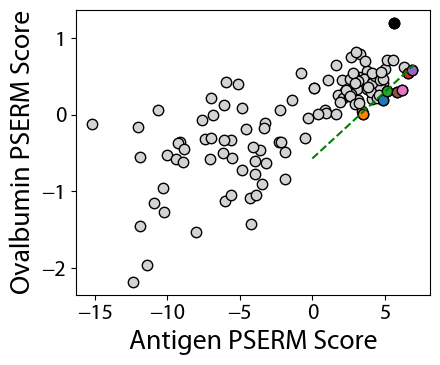

In [10]:
fig, ax = plt.subplots(figsize = (7.2/1.6, 6/1.6))
from scipy.stats import linregress

p = np.array([[3.5, 0.04], [7, 0.65]])

lr = linregress(p[:,0], p[:, 1])

coopt_clones = {}

ax.plot(p1_binding['ANT PSERM Score'], p1_binding['OVA PSERM Score'], '.', color = 'lightgrey', markersize = 15, markeredgecolor = 'k')
ax.plot(p1_binding.loc[p1_data.wt, 'ANT PSERM Score'], p1_binding.loc[p1_data.wt, 'OVA PSERM Score'], '.', color = 'k', markersize = 15)

for c in p1_binding.index:
    x = p1_binding.loc[c, 'ANT PSERM Score']
    y = p1_binding.loc[c, 'OVA PSERM Score']
    if x > 1:
        if y < lr.slope * x +lr.intercept:
            ax.plot(x, y, '.', markersize = 15, markeredgecolor = 'k')
            coopt_clones[c] = [p1_binding.loc[c, 'ANT Binding'], p1_binding.loc[c, 'OVA Binding'], x, y]
ax.plot([0, p[1, 0]], [lr.intercept, p[1, 1]], '--', color = 'green')
#ax.plot([0, 0], [-2.4, lr.intercept], '--', color = 'green')
coopt_clones = pd.DataFrame.from_dict(coopt_clones, orient = 'index', columns = ['ANT Binding', 'OVA Binding', 'ANT PSERM Score', 'OVA PSERM Score'])

ax.set_xlabel('Antigen PSERM Score', fontproperties = prop)
ax.set_ylabel('Ovalbumin PSERM Score', fontproperties = prop)

ax.set_yticks([-2, -1, 0, 1])
for tick in ax.get_xticklabels():
    tick.set_fontproperties(tickprop)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(tickprop)

plt.tight_layout()
plt.savefig('Fig. 5A (Selection).pdf', transparent = True)
plt.show()

c = p1_data.wt
coopt_clones.loc[c, 'ANT Binding'] = p1_binding.loc[c, 'ANT Binding']
coopt_clones.loc[c, 'OVA Binding'] = p1_binding.loc[c, 'OVA Binding']
coopt_clones.loc[c, 'ANT PSERM Score'] = p1_binding.loc[c, 'ANT PSERM Score']
coopt_clones.loc[c, 'OVA PSERM Score'] = p1_binding.loc[c, 'OVA PSERM Score']

last_row = coopt_clones.iloc[[-1]]

# concatenate last row with rest of the dataframe without the last row
coopt_clones = pd.concat([last_row, coopt_clones.iloc[:-1]])


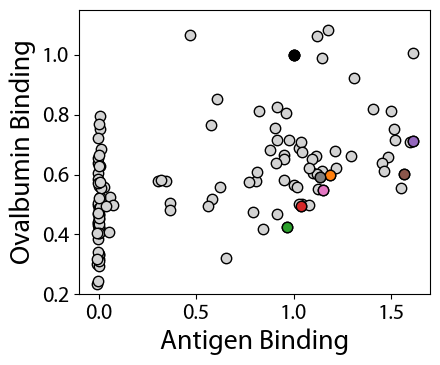

In [11]:
fig, ax = plt.subplots(figsize = (7.2/1.6, 6/1.6))

ax.plot(p1_binding['ANT Binding'], p1_binding['OVA Binding'], '.', markersize = 15, markeredgecolor = 'k', color = 'lightgrey')

for c in coopt_clones.index:
    ax.plot(
        p1_binding.loc[c, 'ANT Binding'], 
        p1_binding.loc[c, 'OVA Binding'], 
        '.', markersize = 15, markeredgecolor = 'k')

ax.plot(p1_binding.loc[p1_data.wt, 'ANT Binding'], p1_binding.loc[p1_data.wt, 'OVA Binding'], '.', color = 'k', markersize = 15)
ax.set_xlabel('Antigen Binding', fontproperties = prop)
ax.set_ylabel('Ovalbumin Binding', fontproperties = prop)
ax.set_xticks([0, 0.5, 1, 1.5])
for tick in ax.get_xticklabels():
    tick.set_fontproperties(tickprop)
for tick in ax.get_yticklabels():
    tick.set_fontproperties(tickprop)

ax.set_xlim(-0.1, 1.7)
ax.set_ylim(0.2,1.15)

plt.tight_layout()
plt.savefig('Fig. 5B (Measurement).pdf', transparent = True)
plt.show()

bdat NOT subset; don't know how to subset; dropped
bloc NOT subset; don't know how to subset; dropped


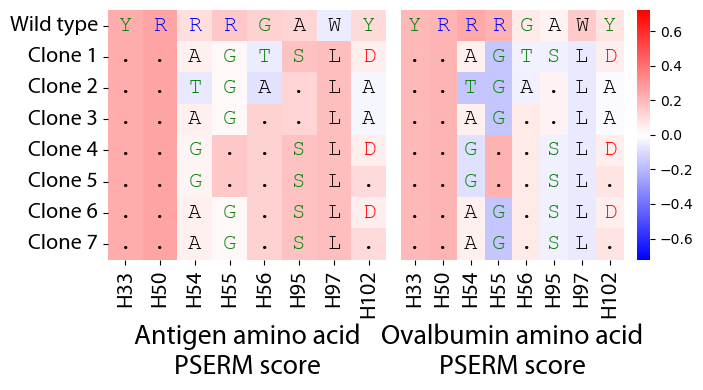

In [84]:
clones_to_show = coopt_clones.index.values
ant_scores_to_show = np.zeros(shape = (len(coopt_clones), len(p1_data.wt)))
ova_scores_to_show = np.zeros(shape = (len(coopt_clones), len(p1_data.wt)))

aapropbold = fm.FontProperties(fname = aapath, size = 16, weight = 'extra bold')

for i, seq in enumerate(clones_to_show):
    for j, aa in enumerate(seq):
        ant_scores_to_show[i, j] = p1_data.PSERM['Ag01_P'].loc[aa, j]
        ova_scores_to_show[i, j] = p1_data.PSERM['Ova_P'].loc[aa, j]

fig, axs = plt.subplots(1, 2, figsize = (7.2, 4))

sns.heatmap(ant_scores_to_show,
            cmap = 'bwr', 
            center = 0, vmin = p1_data.PSERM['Ag01_P'].min().min(), vmax = p1_data.PSERM['Ag01_P'].max().max(),
            ax = axs[0], cbar = False)
sns.heatmap(ova_scores_to_show,
            cmap = 'bwr', 
            center = 0, vmin = p1_data.PSERM['Ova_P'].min().min(), vmax = -p1_data.PSERM['Ova_P'].min().min(),
            ax = axs[1])#, cbar = False)

columns = ['H33', 'H50', 'H54', 'H55', 'H56', 'H95', 'H97', 'H102']

labels = []
for i, seq in enumerate(clones_to_show):
    if seq != p1_data.wt:
        labels.append(f'Clone {i}')
    else:
        labels.append('Wild type')

for ax in axs.ravel():
    ax.set_xticks([i + 0.5 for i in range(len(columns))])
    ax.set_xticklabels(columns, fontproperties = tickprop, rotation = 90)
    
        

axs[0].set_yticks([i + 0.5 for i in list(range(len(labels)))])
axs[1].set_yticks([])
axs[0].set_yticklabels(labels, fontproperties = tickprop, rotation = 0)

axs[0].set_xlabel('Antigen amino acid\nPSERM score', fontproperties = prop)
axs[1].set_xlabel('Ovalbumin amino acid\nPSERM score', fontproperties = prop)

for i, seq in enumerate(clones_to_show):
    for j, AA in enumerate(seq):
        #labels score on i, AA in PSSM
        if AA != p1_data.wt[j] or i == 0:
            for ax in axs.ravel():
                ax.text(
                    j + 0.5, 
                    i + 0.5,  
                    AA,
                    ha = 'center', va = 'center', fontproperties = aapropbold,
                    color = 'k'
                )
        else:
            for ax in axs.ravel():
                ax.text(
                    j + 0.5, 
                    i + 0.5,  
                    '.',
                    ha = 'center', va = 'center', fontproperties = aapropbold,
                    color = 'k'
                )
    #ax.text(
    #    j + 2,
    #    i,
    #    round(p1_data.scores.loc[seq, 'R7 PSERM Score'], 2),
    #    ha = 'right', va = 'center', fontproperties = prop
    #)
plt.tight_layout()
plt.savefig('Fig. 5C (Mutation Scores).pdf')
plt.show()